# EDA Anailisis de Fraude

### Case of Study:

Creation of a model, using machine learning algorithms, that is able to identify a possibility of a transaction to be fraudulent or not.

In [1]:
# Importamo las librerías a utilizar

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
from matplotlib.pyplot import *
from sklearn.impute import KNNImputer
import scipy.stats as ss
from scipy.spatial import distance
from IPython.display import Image
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from pyarrow.parquet import ParquetDataset as pq
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, plot_confusion_matrix
# import xgboost as xgb
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

### Creation of the different functions that are going to be use in the analysis

In [2]:
# Esta funcion ayuda al momento de visualizacion de las diferentes variables dentro del dataset para poder comparar en base 
#la funcion objetivo como es el comportamiento de la demas variables

def plot_feature(df, col_name, isContinuous, target):
    """
    Visualize a variable with and without faceting on the loan status.
    - df dataframe
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    count_null = df[col_name].isnull().sum()
    if isContinuous:
        
        sns.histplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(col_name+ ' Numero de nulos: '+str(count_null))
    plt.xticks(rotation = 90)


    if isContinuous:
        sns.boxplot(x=col_name, y=target, data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(col_name + ' by '+target)
    else:
        data = df.groupby(col_name)[target].value_counts(normalize=True).to_frame('proportion').reset_index() 
        data.columns = [i, target, 'proportion']
        #sns.barplot(x = col_name, y = 'proportion', hue= target, data = data, saturation=1, ax=ax2)
        sns.barplot(x = col_name, y = 'proportion', hue= target, data = data, saturation=1, ax=ax2)
        ax2.set_ylabel(target+' fraction')
        ax2.set_title(target)
        plt.xticks(rotation = 90)
    ax2.set_xlabel(col_name)
    
    plt.tight_layout()

def get_deviation_of_mean_perc(pd_data, list_variables_numericas, target, multiplier):
    """
    Devuelve el porcentaje de valores que exceden del intervalo de confianza
    :type series:
    :param multiplier:
    :return:
    """
    pd_final = pd.DataFrame()
    
    for i in list_variables_numericas:
        
        series_mean = pd_data[i].mean()
        series_std = pd_data[i].std()
        std_amp = multiplier * series_std
        left = series_mean - std_amp
        right = series_mean + std_amp
        size_s = pd_data[i].size
        
        perc_goods = pd_data[i][(pd_data[i] >= left) & (pd_data[i] <= right)].size/size_s
        perc_excess = pd_data[i][(pd_data[i] < left) | (pd_data[i] > right)].size/size_s
        
        if perc_excess>0:    
            pd_concat_percent = pd.DataFrame(pd_data[target][(pd_data[i] < left) | (pd_data[i] > right)]\
                                            .value_counts(normalize=True).reset_index()).T
            pd_concat_percent.columns = [pd_concat_percent.iloc[0:], 
                                          pd_concat_percent.iloc[0:]]
            pd_concat_percent = pd_concat_percent.drop('index',axis=0)
            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_outlier_values'] = pd_data[i][(pd_data[i] < left) | (pd_data[i] > right)].size
            pd_concat_percent['porcentaje_sum_outliers'] = perc_excess
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True)
            
    if pd_final.empty:
        print('No existen variables con valores nulos')
        
    return pd_final


def get_corr_matrix(dataset = None, metodo='pearson', size_figure=[10,8]):
    # Para obtener la correlación de Spearman, sólo cambiar el metodo por 'spearman'

    if dataset is None:
        print(u'\nHace falta pasar argumentos a la función')
        return 1
    sns.set(style="white")
    # Compute the correlation matrix
    corr = dataset.corr(method=metodo) 
    # Set self-correlation to zero to avoid distraction
    for i in range(corr.shape[0]):
        corr.iloc[i, i] = 0
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=size_figure)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, center=0,
                square=True, linewidths=.5,  cmap ='viridis' ) #cbar_kws={"shrink": .5}
    plt.show()
    
    return 0

# # Esta funcion se encarga de identificar las variables categoricas y colocarlas dentro de una lista especifica. Las 
# #variables que se muestran como numericas se recopilan en otra lista.
def dame_variables_categoricas(dataset=None):
    if dataset is None:
        print(u'\nFaltan argumentos por pasar a la función')
        return 1
    lista_variables_categoricas = []
    other = []
    for i in dataset.columns:
        if (dataset[i].dtype!=float) & (dataset[i].dtype!=int):
            unicos = int(len(np.unique(dataset[i].dropna(axis=0, how='all'))))
            if unicos < 100:
                lista_variables_categoricas.append(i)
            else:
                other.append(i)

    return lista_variables_categoricas, other

## Dictionary used

## Creation of the dataframes and verification of the data loaded in the dataframes
(Creacion de dataframes y verificacion de los datos a analizar dentro de los dataframes)

In [3]:
# Importamos el set de datos que vamos a utilizar en el analisis
url="C:/Users/karla/Documents/CUNEF/5_machine_learning/2_practicas/Fraude/data/Copia de Original_dataset_payments_fraud.csv"

df_fraud=pd.read_csv(url, sep=';')
df_fraud.head()

# Trabajamos parquet files
# parquet_file.to_parquet("C:\\Users\\DobleP\\Desktop\\FraudeTransacciones\\Copia de Original_dataset_payments_fraud.csv")
# data = pd.read_parquet(parquet_file, engine = 'auto')

,step,type,amount,gender,device,connection_time,nameOrig,race,oldbalanceOrg,age,newbalanceOrig,zone,user_number,nameDest,user_connections,security_alert,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,man,mac,"0,140039412",C1231006815,black,170136.0,85,160296.36,capital,138,M1979787155,5,1,0.0,0.0,0
1,1,PAYMENT,1864.28,woman,mac,"0,496889534",C1666544295,asian,21249.0,57,19384.72,country,909,M2044282225,1,0,0.0,0.0,0
2,1,TRANSFER,181.00,man,pc,"0,781150327",C1305486145,asian,181.0,66,0.00,capital,2569,C553264065,10,0,0.0,0.0,1
3,1,CASH_OUT,181.00,man,mac,"0,565068378",C840083671,black,181.0,31,0.00,country,1787,C38997010,3,0,21182.0,0.0,1
4,1,PAYMENT,11668.14,unknow,mac,"0,517114493",C2048537720,black,41554.0,90,29885.86,country,3997,M1230701703,8,0,0.0,0.0,0


In [4]:
#Hacemos transformacion de variables para las que se encuentran con un formato incorrecto
df_fraud=df_fraud.assign(**{'connection_time':lambda df: df['connection_time'].str.replace(',','.').astype(float)})
df_fraud.shape

(1048575, 19)

In [5]:
#Eliminamos algunas columnas que contienen variables sensibles para el analisis
df_fraud=df_fraud.drop(["nameOrig","race","nameDest"],axis=1)
df_fraud

,step,type,amount,gender,device,connection_time,oldbalanceOrg,age,newbalanceOrig,zone,user_number,user_connections,security_alert,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,man,mac,0.140039,170136.00,85,160296.36,capital,138,5,1,0.00,0.00,0
1,1,PAYMENT,1864.28,woman,mac,0.496890,21249.00,57,19384.72,country,909,1,0,0.00,0.00,0
2,1,TRANSFER,181.00,man,pc,0.781150,181.00,66,0.00,capital,2569,10,0,0.00,0.00,1
3,1,CASH_OUT,181.00,man,mac,0.565068,181.00,31,0.00,country,1787,3,0,21182.00,0.00,1
4,1,PAYMENT,11668.14,unknow,mac,0.517114,41554.00,90,29885.86,country,3997,8,0,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,95,CASH_OUT,132557.35,woman,mac,0.420243,479803.00,39,347245.65,NaN,3179,9,0,484329.37,616886.72,0
1048571,95,PAYMENT,9917.36,woman,mac,0.376169,90545.00,36,80627.64,africa,2558,9,0,0.00,0.00,0
1048572,95,PAYMENT,14140.05,unknow,pc,0.837109,20545.00,31,6404.95,africa,1553,2,0,0.00,0.00,0
1048573,95,PAYMENT,10020.05,man,mac,0.480931,90605.00,94,80584.95,country,642,8,0,0.00,0.00,0


In [6]:
# Comprobamos que las columnas fueron correctamente eliminadas del dataset y la informacion que se encuentra en el dataset
#fue correctamente transformada
df_fraud.shape

(1048575, 16)

In [7]:
# Verificamos el tipo de datos que se encuentra dentro de cada columna del dataframe, para verificar si categorias actuales
# del dataset esten correctamente descritas para cada variable
df_fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 16 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   step              1048575 non-null  int64  
 1   type              1048575 non-null  object 
 2   amount            1048575 non-null  float64
 3   gender            943457 non-null   object 
 4   device            943995 non-null   object 
 5   connection_time   1048575 non-null  float64
 6   oldbalanceOrg     1048575 non-null  float64
 7   age               1048575 non-null  int64  
 8   newbalanceOrig    1048575 non-null  float64
 9   zone              944161 non-null   object 
 10  user_number       1048575 non-null  int64  
 11  user_connections  1048575 non-null  int64  
 12  security_alert    1048575 non-null  int64  
 13  oldbalanceDest    1048575 non-null  float64
 14  newbalanceDest    1048575 non-null  float64
 15  isFraud           1048575 non-null  int64  
dtype

In [8]:
df_fraud.nunique()

step                     95
type                      5
amount              1009606
gender                    3
device                    3
connection_time     1047989
oldbalanceOrg        415945
age                      96
newbalanceOrig       466415
zone                      3
user_number            4942
user_connections         10
security_alert            2
oldbalanceDest       603920
newbalanceDest       446071
isFraud                   2
dtype: int64

In [9]:
# Tipos de variable que tenemos en nuestro dataset(despues de la conversion, por supuesto.)
df_fraud.dtypes.sort_values().to_frame("Type_variable").groupby(by="Type_variable").size().to_frame('count').reset_index()

,Type_variable,count
0,int64,6
1,float64,6
2,object,4


**ENGL**
- **All variables that may be sensible or not relevent to the analysis were eliminated**, and also the transformation of the variable of "cinnection_time" was correctly assign to the correct type. 
- From the total amount of variables obtain, in the dataset that will be worked we have **6 interger, 6 floats and 4 character variables**.

### Split numerical and categorical variables
(Separacion de variables categoricas y variables numericas)

In [10]:
# Para la diferenciacion, usamos el codigo reset_index para reiniciar el indice y poder unir las tablas posteriormente. 
variables_categoricas = df_fraud[['type', 'gender', 'device', 'zone']].astype(str).reset_index()

variables_numericas = df_fraud[['step', 'amount', 'user_connections', 'user_number', 'age', 'connection_time', 'oldbalanceOrg',
                           'newbalanceOrig', 'security_alert','oldbalanceDest', 'newbalanceDest','isFraud']].astype(float).reset_index()

# Realizamos la union de las tablas y le asignamos el nombre de variables_numericas y variables_categoricas.
data = pd.merge(variables_categoricas,variables_numericas, how='inner', on=['index']).drop(["index"], axis =1)
data.info()

variables_numericas = variables_numericas.drop(["index"], axis =1).astype(float)
variables_categoricas = variables_categoricas.drop(["index"], axis =1).astype(str)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048575 entries, 0 to 1048574
Data columns (total 16 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   type              1048575 non-null  object 
 1   gender            1048575 non-null  object 
 2   device            1048575 non-null  object 
 3   zone              1048575 non-null  object 
 4   step              1048575 non-null  float64
 5   amount            1048575 non-null  float64
 6   user_connections  1048575 non-null  float64
 7   user_number       1048575 non-null  float64
 8   age               1048575 non-null  float64
 9   connection_time   1048575 non-null  float64
 10  oldbalanceOrg     1048575 non-null  float64
 11  newbalanceOrig    1048575 non-null  float64
 12  security_alert    1048575 non-null  float64
 13  oldbalanceDest    1048575 non-null  float64
 14  newbalanceDest    1048575 non-null  float64
 15  isFraud           1048575 non-null  float64
dtype

In [11]:
list_variables_categoricas, other = dame_variables_categoricas(dataset = data)
df_fraud[list_variables_categoricas] = df_fraud[list_variables_categoricas].astype("category")
list_variables_numericas = list(data.select_dtypes("float").columns)
df_fraud[list_variables_numericas] = df_fraud[list_variables_numericas].astype(float)
df_fraud.dtypes

step                 float64
type                category
amount               float64
gender              category
device              category
connection_time      float64
oldbalanceOrg        float64
age                  float64
newbalanceOrig       float64
zone                category
user_number          float64
user_connections     float64
security_alert       float64
oldbalanceDest       float64
newbalanceDest       float64
isFraud              float64
dtype: object

## Verification of duplicate values, missing values and outliers
(Verificacion de datos duplicados, datos faltantes y outliers)

### - Duplicates rows / Verificacion de filas duplicadas

In [12]:
# verificamos si existen duplicados para identificar como proceder csi existe gran cantidad
print(df_fraud.shape, df_fraud.drop_duplicates().shape)

(1048575, 16) (1048575, 16)


**ENG** -There are **no duplicated rows** in our dataset\

### -Missing Values / Verificar de valores nulos

In [13]:
# Creamos una tabla para verificar cuantas de nuestras varaibles contenian valores faltantes
null_columns=df_fraud.isnull().sum().sort_values(ascending=False).rename("null_values").reset_index()
total_rows=df_fraud.count().rename("total_rows").astype(int).reset_index()

null_columns=pd.merge(null_columns,total_rows, how="inner", on=["index"])
null_columns["miss_percentage"]=(null_columns['null_values']/len(df_fraud)).mul(100)
null_columns[null_columns["null_values"]>0]

,index,null_values,total_rows,miss_percentage
0,gender,105118,943457,10.024843
1,device,104580,943995,9.973536
2,zone,104414,944161,9.957705


In [14]:
#Verificamos los missing values de la columna 'Zone' para identificar como tratar los valores nulos
df_null_zone=df_fraud[pd.isnull(df_fraud["zone"])]
df_null_zone

,step,type,amount,gender,device,connection_time,oldbalanceOrg,age,newbalanceOrig,zone,user_number,user_connections,security_alert,oldbalanceDest,newbalanceDest,isFraud
11,1.0,PAYMENT,3099.97,NaN,pc,0.863282,20771.00,42.0,17671.03,NaN,4836.0,1.0,0.0,0.00,0.00,0.0
15,1.0,CASH_OUT,229133.94,unknow,mac,0.362496,15325.00,39.0,0.00,NaN,1878.0,1.0,0.0,5083.00,51513.44,0.0
19,1.0,TRANSFER,215310.30,woman,NaN,0.901635,705.00,98.0,0.00,NaN,2048.0,2.0,0.0,22425.00,0.00,0.0
27,1.0,PAYMENT,8009.09,man,mac,0.465050,10968.00,64.0,2958.91,NaN,3527.0,4.0,0.0,0.00,0.00,0.0
28,1.0,PAYMENT,8901.99,NaN,pc,0.798794,2958.91,100.0,0.00,NaN,3499.0,7.0,0.0,0.00,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048534,95.0,PAYMENT,35615.13,unknow,pc,0.661050,0.00,35.0,0.00,NaN,2602.0,2.0,0.0,0.00,0.00,0.0
1048538,95.0,PAYMENT,792.07,woman,mac,0.299582,0.00,23.0,0.00,NaN,2165.0,10.0,0.0,0.00,0.00,0.0
1048541,95.0,PAYMENT,14851.50,woman,mac,0.463062,0.00,91.0,0.00,NaN,1914.0,8.0,0.0,0.00,0.00,0.0
1048547,95.0,PAYMENT,12610.69,woman,iphone,0.243083,0.00,24.0,0.00,NaN,3245.0,6.0,0.0,0.00,0.00,0.0


**ENG**- We do not know if these values as nulls were entered randomly or if they were not introduced due to information that was not entered on purpose, we will be classifying these nulls as MAR(missing at Random) or MNAR(missing not at random). Therefore we are going to change the null values to "missing" to be able to work with Machine Learning models but also taking these missing values into account.

In [15]:
# Creating changing the NaN with missing values
df_fraud['gender']=np.where(df_fraud['gender'].isnull(),"unknow",df_fraud['gender'])
df_fraud['zone']=np.where(df_fraud['zone'].isnull(),"missing",df_fraud['zone'])
df_fraud['device']=np.where(df_fraud['device'].isnull(),"missing",df_fraud['device'])

In [16]:
# Creamos una tabla para verificar cuantas de nuestras varaibles contenian valores faltantes
null_columns=df_fraud.isnull().sum().sort_values(ascending=False).rename("null_values").reset_index()
total_rows=df_fraud.count().rename("total_rows").astype(int).reset_index()

null_columns=pd.merge(null_columns,total_rows, how="inner", on=["index"])
null_columns["miss_percentage"]=(null_columns['null_values']/len(df_fraud)).mul(100)
null_columns[null_columns["null_values"]>0]

,index,null_values,total_rows,miss_percentage


**Columsn/Rows**

**ENG** - The analysis of null values shows that in the variables **"gender", "device and "zone" there are between 10 and 9 % of the data that are missing**, we decide to create a new variable on each column known as "missing" to highlight the NaN values but also to be able to work with the data in the future prediction models.

### -Outliers /  Verificacion de outliers

In [17]:
print(len(df_fraud))
get_deviation_of_mean_perc(df_fraud, list_variables_numericas, target='isFraud', multiplier = 3)

1048575


,0,1,variable,sum_outlier_values,porcentaje_sum_outliers
,0,1,,,
0,0.986447,0.013553,step,18004,0.017170
1,0.981773,0.018227,amount,19422,0.018522
2,0.999311,0.000689,oldbalanceOrg,26140,0.024929
3,1.000000,NaN,newbalanceOrig,26282,0.025064
4,0.999427,0.000573,oldbalanceDest,22685,0.021634
5,0.998513,0.001487,newbalanceDest,22862,0.021803
6,1.000000,NaN,isFraud,1142,0.001089


**ENG**- In total we have 7 columns that have outliers. As the column with the most outliers only represents 2.5% of the total data, we have decided to continue working with these atypical data knowing that we have some outliers in our dataset.

## Verification of Target Variable
(Verificacion de la variable objetivo a trabajar)

In [18]:
# Verificamos el comportamiento de la variable objetivo dentro de nuestro dataset para identificar como se procederan a 
# dividir el set de datos de training y el de test
df_fraud_porc=df_fraud.isFraud.value_counts(normalize=True).rename("porcentaje").mul(100).reset_index().round(2)
df_fraud_cant=df_fraud.isFraud.value_counts().rename("cantidad").reset_index()

df_isFraud=pd.merge(df_fraud_porc, df_fraud_cant, how= "inner", on=["index"])
df_isFraud=pd.DataFrame(df_isFraud)
df_isFraud

,index,porcentaje,cantidad
0,0.0,99.89,1047433
1,1.0,0.11,1142


Text(0.5, 1.05, 'Distribution Target Variable / Distribucion Variable Objetivo')

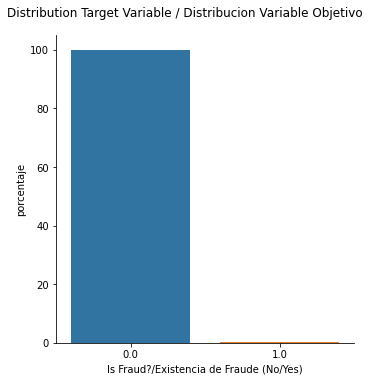

In [19]:
graph=sns.catplot(data=df_isFraud, x="index", y="porcentaje", kind="bar")
graph.set(xlabel="Is Fraud?/Existencia de Fraude (No/Yes)")
graph.fig.suptitle("Distribution Target Variable / Distribucion Variable Objetivo", y=1.05)

**ENG**
- In the graph above the 0 represents the transactions that were not fraudulent and the 1 represents the transactions that were fraud. The target varaible is unbalance as the observations that were fraud were far less than the transactions that were not a fraud with a difference in percecntage of 99.89% against 0.11% of transactions that were fraud.
- This will impact the way we are will besplitting the dataset of training and test in further process.

## Behavior of variables 
(Comportamiento de variables a analizar)

**ENG** 
- Because of the big amount of data in the dataset, we are going to select some variables and analyse their behavior by themself and comparing the varaible against the target variable. We select the 3 varaiables that had missing values (gender, zone and device) and type of transaction, age and amount.

**1. Age Variable**

Text(0.5, 1.0, 'Comportamiento variable de edad en relacion a Fraude')

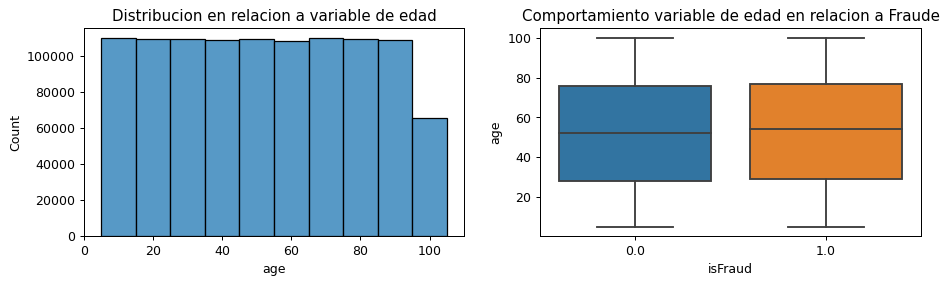

In [20]:
# Analisis de la variable de edad
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
sns.histplot(data=df_fraud, x='age', binwidth=10, ax=ax1)
sns.boxplot(x='isFraud', y='age', data=df_fraud, ax=ax2,)
ax1.set_title("Distribucion en relacion a variable de edad")
ax2.set_title("Comportamiento variable de edad en relacion a Fraude")

In [21]:
df_fraud.age.groupby(df_fraud.age).count().to_frame().head(5)

,age
age,
5.0,11055
6.0,10843
7.0,11088
8.0,10980
9.0,10830


**ENG** - For the age, it is shown that there are a lot of transactions that were executed bby people less than 18 years old, being the minimun age to execute a transaction 18. Regardless the distribution of the data, when we compare this variable against the target variable we can see that the distribution of age for the transactions that were fraudulent and the ones that were not fraudulent are the same. This shows that the variable of age does not have a lot of influence in the target variable and therefore we are going to drop this columns category.

In [22]:
df_fraud=df_fraud.drop(['age'],axis=1)

Text(0.5, 1.0, 'Behavior of var. amount vs Fraud')

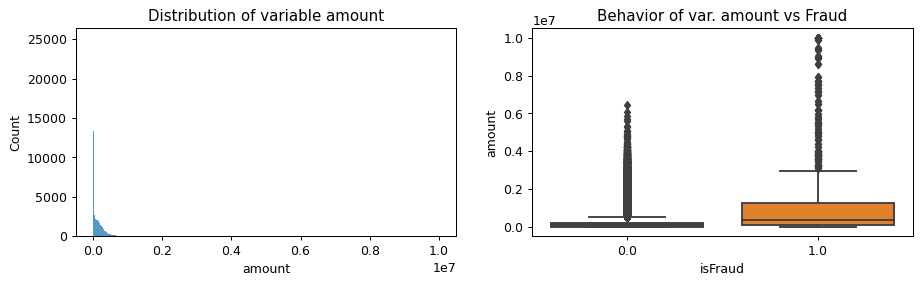

In [23]:
# Analisis de la variable de cantidad
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
sns.histplot(data=df_fraud, x='amount', binwidth=1000, ax=ax1)
sns.boxplot(x='isFraud', y='amount', data=df_fraud, ax=ax2)
ax1.set_title("Distribution of variable amount")
ax2.set_title("Behavior of var. amount vs Fraud")

**2. Amount Variable**

**ENG** - Even though it can be identify that there are a lot of outliers in this variable, **the behavior of the amount of the transaction has an impact on the object variable (isFraud)**. With the boxplot it can be perceived that the amount of money of the transactions that are a Fraud are a higher than the transaction that are not a Fraud, with a median and a range with a bigger dimension.

**3. Type Variable**

In [24]:
# Hemos creado un nuevo dataframe solo con los datos en que las transacciones fueron farude para analizar mejor en graficos
df_fraud_yes=df_fraud.loc[df_fraud['isFraud']==1]

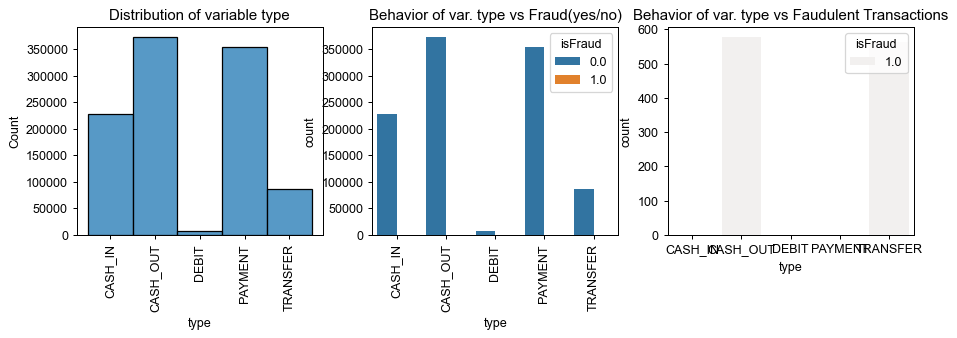

In [25]:
# Analisamos las variables de "type" para verificar comportamiento
f, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12,3), dpi=90)

sns.histplot(data=df_fraud, x='type', ax=ax1)
sns.countplot(x='type', data=df_fraud, hue='isFraud', ax=ax2)
sns.countplot(x='type', data=df_fraud_yes, hue='isFraud', ax=ax3, color="orange")

ax1.set_title("Distribution of variable type")
ax2.set_title("Behavior of var. type vs Fraud(yes/no)")
ax3.set_title("Behavior of var. type vs Faudulent Transactions")

sns.set(font_scale = 0.7)
ax1.tick_params(axis='x', rotation=90)
ax2.tick_params(axis='x', rotation=90)

In [26]:
# Vemos distribucion en funcion numerica para una mejor comparacion
df_noFraud=df_fraud.loc[(df_fraud['isFraud'] == 0),['isFraud','type']].groupby('type').count().reset_index().set_axis(["type","noFraud"],axis=1)
df_yesFraud=df_fraud.loc[(df_fraud['isFraud'] == 1),['isFraud','type']].groupby('type').count().reset_index().set_axis(["type","yesFraud"],axis=1)
df_Fraud_type=pd.merge(df_noFraud,df_yesFraud, how= "left", on=["type"])
df_Fraud_type

,type,noFraud,yesFraud
0,CASH_IN,227130,0
1,CASH_OUT,373063,578
2,DEBIT,7178,0
3,PAYMENT,353873,0
4,TRANSFER,86189,564


**ENG**- Eventhough the transactions that were fraud are not visible in the column chart, the table created showns that the transactions that were classified as fraud only were the type of cashing out money or by transaction. The types that were cash_in, debit or payment were never a fraudulent transactions, **this is a variable that indeeed have an importan role in our future analysis**

**4. Gender Variable**

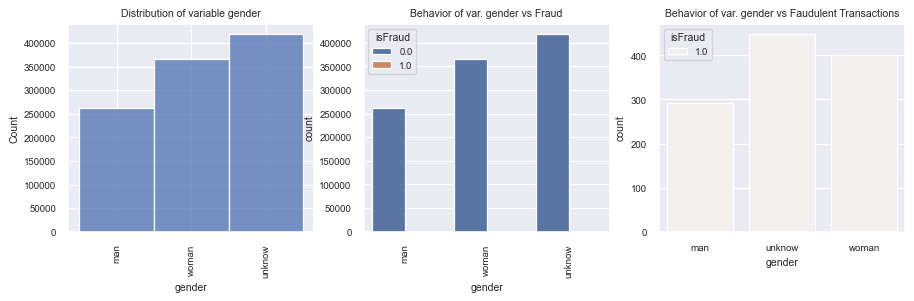

In [27]:
# Analisamos las variables de "gender" para verificar comportamiento
f, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12,3), dpi=90)

sns.histplot(data=df_fraud, x='gender', ax=ax1, stat='count')
sns.countplot(x='gender', data=df_fraud, hue='isFraud', ax=ax2)
sns.countplot(x='gender', data=df_fraud_yes, hue='isFraud', ax=ax3, color="orange")

ax1.set_title("Distribution of variable gender")
ax2.set_title("Behavior of var. gender vs Fraud")
ax3.set_title("Behavior of var. gender vs Faudulent Transactions")

sns.set(font_scale = 0.7)
ax1.tick_params(axis='x', rotation=90)
ax2.tick_params(axis='x', rotation=90)

In [28]:
# Vemos distribucion en funcion numerica para una mejor comparacion
df_noFraud=df_fraud.loc[(df_fraud['isFraud'] == 0),['isFraud','gender']].groupby('gender').count().reset_index().set_axis(["gender","noFraud"],axis=1)
df_yesFraud=df_fraud.loc[(df_fraud['isFraud'] == 1),['isFraud','gender']].groupby('gender').count().reset_index().set_axis(["gender","yesFraud"],axis=1)
df_Fraud_gender=pd.merge(df_noFraud,df_yesFraud, how= "inner", on=["gender"])
df_Fraud_gender

,gender,noFraud,yesFraud
0,man,261951,293
1,unknow,418976,449
2,woman,366506,400


**ENG**- With the variable of gender, we can see that the distribution of the transaction taht were fraud is almost equal as the distribution of transactions that were not fraud. So this varaible does not play an important role in the target varaible.

**5. Zone Variable**

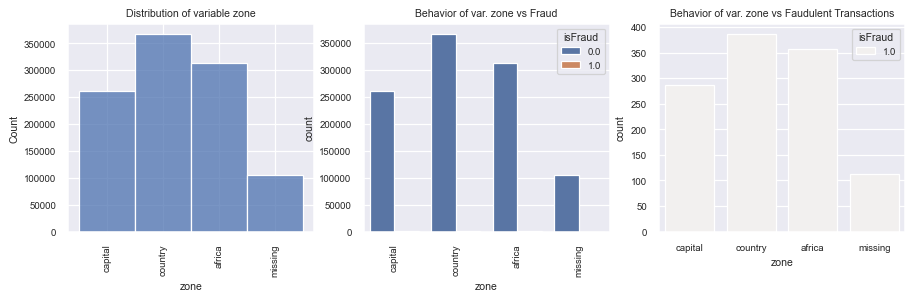

In [29]:
# Analisamos las variables de "gender" para verificar comportamiento
f, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12,3), dpi=90)

sns.histplot(data=df_fraud, x='zone', ax=ax1, stat='count')
sns.countplot(x='zone', data=df_fraud, hue='isFraud', ax=ax2)
sns.countplot(x='zone', data=df_fraud_yes, hue='isFraud', ax=ax3, color="orange")

ax1.set_title("Distribution of variable zone")
ax2.set_title("Behavior of var. zone vs Fraud")
ax3.set_title("Behavior of var. zone vs Faudulent Transactions")

sns.set(font_scale = 0.7)
ax1.tick_params(axis='x', rotation=90)
ax2.tick_params(axis='x', rotation=90)

In [30]:
# Vemos distribucion en funcion numerica para una mejor comparacion
df_noFraud=df_fraud.loc[(df_fraud['isFraud'] == 0),['isFraud','zone']].groupby('zone').count().reset_index().set_axis(["zone","noFraud"],axis=1)
df_yesFraud=df_fraud.loc[(df_fraud['isFraud'] == 1),['isFraud','zone']].groupby('zone').count().reset_index().set_axis(["zone","yesFraud"],axis=1)
df_Fraud_zone=pd.merge(df_noFraud,df_yesFraud, how= "inner", on=["zone"])
df_Fraud_zone

,zone,noFraud,yesFraud
0,africa,313670,356
1,capital,261845,286
2,country,367617,387
3,missing,104301,113


**ENGL**- In the table created it's shown that there are no high difference between the zone where the transaction were made and whether the type of transaction were fraud or not. This isnt probably a variable that have a lot of impact on further analysis.

**6. Device Variable**

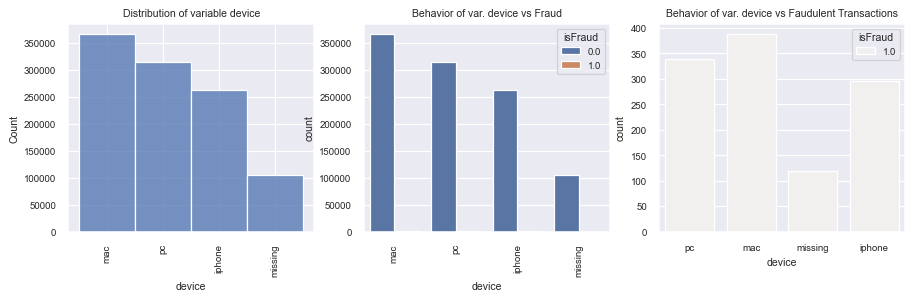

In [31]:
# Analisamos las variables de "device" para verificar comportamiento
f, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12,3), dpi=90)

sns.histplot(data=df_fraud, x='device', ax=ax1, stat='count')
sns.countplot(x='device', data=df_fraud, hue='isFraud', ax=ax2)
sns.countplot(x='device', data=df_fraud_yes, hue='isFraud', ax=ax3, color="orange")

ax1.set_title("Distribution of variable device")
ax2.set_title("Behavior of var. device vs Fraud")
ax3.set_title("Behavior of var. device vs Faudulent Transactions")

sns.set(font_scale = 0.7)
ax1.tick_params(axis='x', rotation=90)
ax2.tick_params(axis='x', rotation=90)

In [32]:
# Vemos distribucion en funcion numerica para una mejor comparacion
df_noFraud=df_fraud.loc[(df_fraud['isFraud'] == 0),['isFraud','device']].groupby('device').count().reset_index().set_axis(["device","noFraud"],axis=1)
df_yesFraud=df_fraud.loc[(df_fraud['isFraud'] == 1),['isFraud','device']].groupby('device').count().reset_index().set_axis(["device","yesFraud"],axis=1)
df_Fraud_device=pd.merge(df_noFraud,df_yesFraud, how= "inner", on=["device"])
df_Fraud_device

,device,noFraud,yesFraud
0,iphone,261767,295
1,mac,366677,389
2,missing,104461,119
3,pc,314528,339


**ENG**- In the table created it's shown that there are no big difference between the device in which the transaction were made and whether the type of transaction were fraud or not. This isnt probably a variable that have a lot of impact on further analysis.

## Correlation between numerical values
(Correlacion existente entre los datos numericos)

In [33]:
list_variables_numericas.remove('age')

In [34]:
data=df_fraud
corr = data[list_variables_numericas].corr('pearson')
new_corr = corr.abs()
new_corr.loc[:,:] = np.tril(new_corr, k=-1)
new_corr = new_corr.stack().to_frame('correlation').reset_index().sort_values(by='correlation', ascending=False)
new_corr[new_corr['correlation']>0.6]

,level_0,level_1,correlation
71,newbalanceOrig,oldbalanceOrg,0.999050
107,newbalanceDest,oldbalanceDest,0.978401


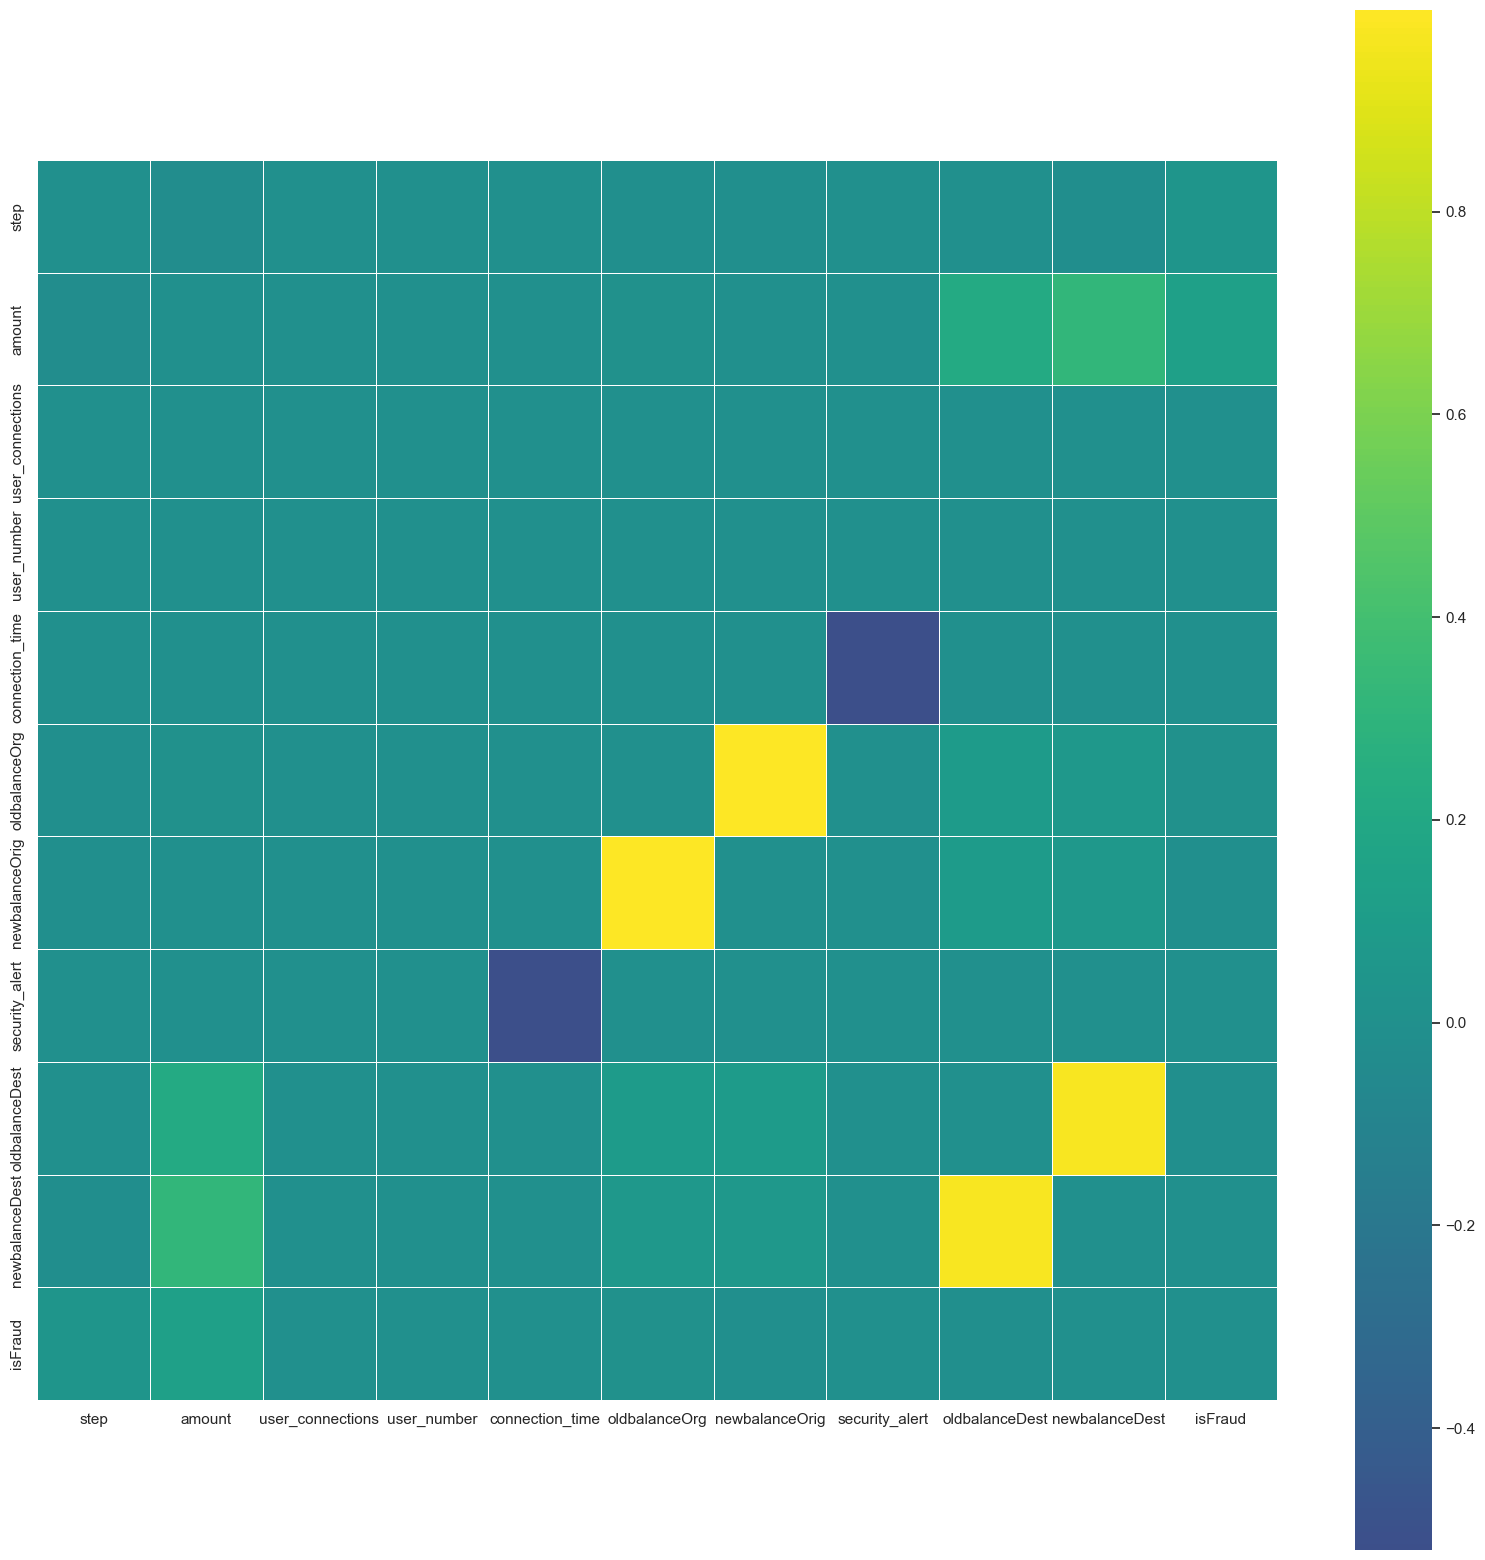

0

In [35]:
get_corr_matrix(dataset = data[list_variables_numericas], 
                metodo='pearson', size_figure=[20,20])

#### Conclusion/ Conclusión

**ENG**-With the correlation analysis we can see that the variables that are positively correlated are the new balance of the recipient ("newbalanceDest") with the old balance of the recipient ("oldbalanceDest"). Similarly, we also have a negative correlation between the number of users connected to the network ("connection_time") and whether a security alert was issued on that day ("security_alert").

## Save the created Dataset
(Guardar el dataset)

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 15 columns):
 #   Column            Non-Null Count    Dtype   
---  ------            --------------    -----   
 0   step              1048575 non-null  float64 
 1   type              1048575 non-null  category
 2   amount            1048575 non-null  float64 
 3   gender            1048575 non-null  object  
 4   device            1048575 non-null  object  
 5   connection_time   1048575 non-null  float64 
 6   oldbalanceOrg     1048575 non-null  float64 
 7   newbalanceOrig    1048575 non-null  float64 
 8   zone              1048575 non-null  object  
 9   user_number       1048575 non-null  float64 
 10  user_connections  1048575 non-null  float64 
 11  security_alert    1048575 non-null  float64 
 12  oldbalanceDest    1048575 non-null  float64 
 13  newbalanceDest    1048575 non-null  float64 
 14  isFraud           1048575 non-null  float64 
dtypes: category(1), float64(11), obj

In [37]:
data.to_csv("C:/Users/karla/Documents/CUNEF/5_machine_learning/2_practicas/Fraude/data/process/pd_datafruad_preprocessing.csv")
data.to_parquet("C:/Users/karla/Documents/CUNEF/5_machine_learning/2_practicas/Fraude/data/process/pd_datafruad_preprocessing.csv")